In [1]:
import numpy as np
import pandas as pd
import bokeh.plotting as bp
from bokeh.layouts import gridplot
#bp.output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%run code/build_dataset.py
%run code/PNLEstimatorWrapper.py
%run code/redim.py
%run code/step_validation.py
%run code/v_split.py

In [3]:
#Se lee la señal anteriormente procesada
data_set = pd.read_csv("./data/TrueFX/USD-JPY/datos_procesados_USDJPY-2018-02.csv")

In [4]:
data_set.head()

,date,bid,ask
0,2018-02-01 01:58:20,109.190,109.194
1,2018-02-01 01:58:30,109.186,109.190
2,2018-02-01 01:58:40,109.183,109.187
3,2018-02-01 01:58:50,109.169,109.173
4,2018-02-01 01:59:00,109.167,109.171


In [5]:
data_set = data_set.set_index(pd.to_datetime(data_set.iloc[:,0])) #se indexan los datos por su fecha y hora
data_set = data_set.drop(['date'],axis=1) #se elimina la columna date

In [6]:
data_set.head()

,bid,ask
date,,
2018-02-01 01:58:20,109.190,109.194
2018-02-01 01:58:30,109.186,109.190
2018-02-01 01:58:40,109.183,109.187
2018-02-01 01:58:50,109.169,109.173
2018-02-01 01:59:00,109.167,109.171


In [7]:
np.unique(data_set.index.date)

array([datetime.date(2018, 2, 1), datetime.date(2018, 2, 2),
       datetime.date(2018, 2, 5), datetime.date(2018, 2, 6),
       datetime.date(2018, 2, 7), datetime.date(2018, 2, 8),
       datetime.date(2018, 2, 9), datetime.date(2018, 2, 12),
       datetime.date(2018, 2, 13), datetime.date(2018, 2, 14),
       datetime.date(2018, 2, 15), datetime.date(2018, 2, 16),
       datetime.date(2018, 2, 19), datetime.date(2018, 2, 20),
       datetime.date(2018, 2, 21), datetime.date(2018, 2, 22),
       datetime.date(2018, 2, 23), datetime.date(2018, 2, 26),
       datetime.date(2018, 2, 27), datetime.date(2018, 2, 28),
       datetime.date(2018, 3, 1)], dtype=object)

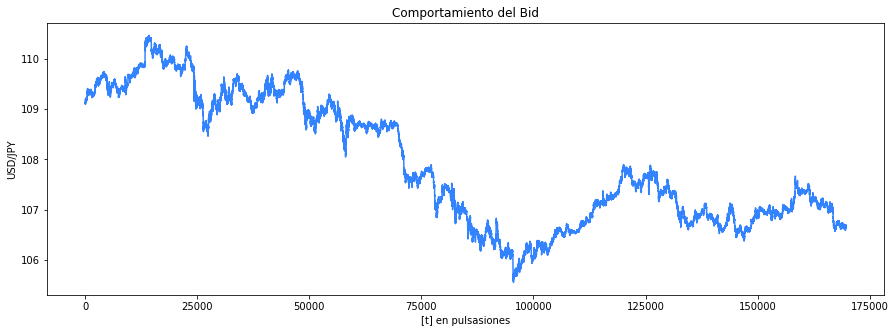

In [8]:
plt.figure(figsize=(15,5))
plt.title('Comportamiento del Bid')
plt.xlabel('[t] en pulsasiones')
plt.ylabel('USD/JPY')
plt.plot(np.arange(data_set.shape[0]), data_set.iloc[:,0], alpha=1, color='#3383FF');

#### Construyendo el Dataset
se prueba con la ventana de tamaño 3, con la que dió mejor resultado en EUR/USD, pero se probará tambien con cual tamaño de ventana funciona mejor.

In [9]:
window = 3
X, y_reg, bt = build_dataset(data_set.iloc[:,0], window, binary_target=True, delete_constant_values=True, PNL=True)

In [10]:
X.shape, y_reg.shape, bt.shape

((150588, 4), (150588,), (150588,))

In [11]:
print(y_reg[:5])
print(bt[:5])

[ 109.169  109.167  109.16   109.169  109.171]
[0 0 0 1 1]


In [12]:
X.head()

,0,1,2,PNL
date,,,,
2018-02-01 01:59:00,109.190,109.186,109.183,-0.014
2018-02-01 01:59:10,109.186,109.183,109.169,-0.002
2018-02-01 01:59:20,109.183,109.169,109.167,-0.007
2018-02-01 01:59:30,109.169,109.167,109.160,0.009
2018-02-01 01:59:40,109.167,109.160,109.169,0.002


In [13]:
# se muestrea la señal a predecir por cada hora para colocar con los buy y sell por dia.
signal_sample = (X.resample('1h',loffset='h').last()).iloc[:,2][1:]

Se prueba con un GaussianNB para ver su rendimiento, esto teniendo cuenta que solo es con un mes de datos

In [14]:
from sklearn.naive_bayes import GaussianNB
    
y = bt
n_bdtrain = 4
n_bdtest = 1
mday = 1

est_GNB = PNLEstimatorWrapper(GaussianNB(), PNL_column='PNL')
result_GNB = step_validation(est_GNB, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_GNB, predict_GNB = redim(result_GNB)
print('--------- GaussianNB ----------------')
print('average PNL : ', np.mean(result_GNB[:,0]))
print('average buy: ', np.mean(result_GNB[:,1]))
print('average sell: ', np.mean(result_GNB[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

--------- GaussianNB ----------------
average PNL :  -0.0848235294118
average buy:  3211.11764706
average sell:  3866.05882353
-------------------------------------
      PNL    buys   sells  longest_buys  longest_sells
0   1.134  5221.0  2506.0        4430.0          637.0
1   0.539  2625.0  5163.0        2043.0         3954.0
2   0.217  7425.0   439.0        4170.0          356.0
3  -0.139  7351.0     0.0        7351.0            0.0
4  -0.687  5727.0  1761.0        5700.0         1752.0
5  -0.842  7674.0     0.0        7674.0            0.0
6  -0.838  7708.0     0.0        7708.0            0.0
7  -0.119     0.0  7611.0           0.0         7611.0
8  -0.347     0.0  6822.0           0.0         6822.0
9  -0.726     0.0  7216.0           0.0         7216.0
10  0.327  7371.0    83.0        7345.0           59.0
11  0.250   994.0  6497.0         395.0         4602.0
12 -0.109     0.0  7314.0           0.0         7314.0
13 -0.066     0.0  7415.0           0.0         7415.0
14 -0.407 

los primeros cuatro días equivalen a 30276 datos del dataset

In [15]:
for i in v_split(X,4,1,1):
    print (i)

(array([    0,     1,     2, ..., 30273, 30274, 30275]), array([30276, 30277, 30278, ..., 38000, 38001, 38002]))
(array([ 6878,  6879,  6880, ..., 38000, 38001, 38002]), array([38003, 38004, 38005, ..., 45788, 45789, 45790]))
(array([14485, 14486, 14487, ..., 45788, 45789, 45790]), array([45791, 45792, 45793, ..., 53652, 53653, 53654]))
(array([22208, 22209, 22210, ..., 53652, 53653, 53654]), array([53655, 53656, 53657, ..., 61003, 61004, 61005]))
(array([30276, 30277, 30278, ..., 61003, 61004, 61005]), array([61006, 61007, 61008, ..., 68491, 68492, 68493]))
(array([38003, 38004, 38005, ..., 68491, 68492, 68493]), array([68494, 68495, 68496, ..., 76165, 76166, 76167]))
(array([45791, 45792, 45793, ..., 76165, 76166, 76167]), array([76168, 76169, 76170, ..., 83873, 83874, 83875]))
(array([53655, 53656, 53657, ..., 83873, 83874, 83875]), array([83876, 83877, 83878, ..., 91484, 91485, 91486]))
(array([61006, 61007, 61008, ..., 91484, 91485, 91486]), array([91487, 91488, 91489, ..., 98306,

In [16]:
firts_4bd = 30276 #primeros 4 días
len(predict_GNB),len(y)- firts_4bd

(120312, 120312)

### Se pintarán las ventas en color rojo y las compras en color verde!

Como para el target se empieza del segundo valor de la fila X, es decir, el primer valor de la señal no tiene una predicción ya que no tiene un valor anterior para ser comparado, por esto se coge la señal "y_reg" y no se toma el último valor ya que este no tiene predicción

In [17]:
#para graficar las compras acertadas sobre la señal original
buy_GNB_ok = ((predict_GNB==bt[firts_4bd:])&(predict_GNB==1))*y_reg[firts_4bd-1:-1]
buy_GNB_ok[buy_GNB_ok==0] = np.nan 
print (buy_GNB_ok.shape)
#para graficar las ventas acertadas sobre la señal original
sell_GNB_ok = ((predict_GNB==bt[firts_4bd:])&(predict_GNB==0))*y_reg[firts_4bd-1:-1]
sell_GNB_ok[sell_GNB_ok==0] = np.nan
print (sell_GNB_ok.shape)

#para graficar las compras fallidas sobre la señal original
buy_GNB_mal = ((predict_GNB!=bt[firts_4bd:])&(predict_GNB==1))*y_reg[firts_4bd-1:-1]
buy_GNB_mal[buy_GNB_mal==0] = np.nan 
print (buy_GNB_mal.shape)
#para graficar las ventas fallidas sobre la señal original
sell_GNB_mal = ((predict_GNB!=bt[firts_4bd:])&(predict_GNB==0))*y_reg[firts_4bd-1:-1]
sell_GNB_mal[sell_GNB_mal==0] = np.nan
print (sell_GNB_mal.shape)

(120312,)
(120312,)
(120312,)
(120312,)


In [18]:
dates = np.unique(data_set.index.date) #para graficar el numero de ventas y compras por dia
x_axis = X.index[firts_4bd:] #para graficar los resultados por datetime

graficando con bokeh

In [20]:
p1_GNB = bp.Figure(width=750, height=300,title='buys and sells with a GaussianNB',x_axis_type='datetime',
               title_location = 'above')
p1_GNB.triangle(x_axis, buy_GNB_ok, color='green', legend='predict buys ok')
p1_GNB.triangle(x_axis, sell_GNB_ok, color='green', legend='predict sells ok', angle=45)
p1_GNB.xaxis.axis_label = 'Datetime'
p1_GNB.yaxis.axis_label = 'USD/JPY'
p1_GNB.triangle(x_axis, buy_GNB_mal, color='red', legend='predict buys bad')
p1_GNB.triangle(x_axis, sell_GNB_mal, color='red', legend='predict sells bad', angle=45)
p1_GNB.line(x_axis, y_reg[firts_4bd-1:-1], color='blue', alpha=0.2, legend='bid')
p1_GNB.legend.location = 'bottom_left'
p1_GNB.legend.orientation = 'horizontal'
p1_GNB.legend.background_fill_color = 'grey'
p1_GNB.legend.background_fill_alpha = 0.1
p1_GNB.legend.border_line_alpha = None

p2_GNB = bp.Figure(width=750, height=300,title='Profit and Loss with a GaussianNB',x_axis_type='datetime')
p2_GNB.line(dates[n_bdtrain:], result_GNB[:,0], color='blue', legend='PNL', alpha=0.5)
p2_GNB.circle(dates[n_bdtrain:], result_GNB[:,0], color='blue', legend='PNL', alpha=0.5)
p2_GNB.line(dates[n_bdtrain:], np.zeros(len(result_GNB)), color='red', legend='PNL = 0', line_dash='dotted')
p2_GNB.line(dates[n_bdtrain:],np.ones(len(result_GNB[:,0]))*np.mean(result_GNB[:,0]),color='green',legend='avg PNL')
p2_GNB.xaxis.axis_label = 'datetime'
p2_GNB.yaxis.axis_label = 'PNL'
p2_GNB.legend.location ='bottom_center'
p2_GNB.legend.orientation = 'horizontal'

p3_GNB = bp.Figure(width=400, height=250, title='buys per day', x_axis_type='datetime')
p3_GNB.line(dates[n_bdtrain:], result_GNB[:,1], color='green')
p3_GNB.circle(dates[n_bdtrain:], result_GNB[:,1], color='green')
p3_GNB.xaxis.axis_label = 'datetime'
p3_GNB.yaxis.axis_label = 'buys per day'
#se utiliza el x_range para correlacionar las dos gráficas por el eje x
p4_GNB = bp.Figure(width=400, height=250, title='sells per day', x_axis_type='datetime',x_range=p3_GNB.x_range)
p4_GNB.line(dates[n_bdtrain:], result_GNB[:,2], color='red')
p4_GNB.circle(dates[n_bdtrain:], result_GNB[:,2], color='red')
p4_GNB.xaxis.axis_label = 'datetime'
p4_GNB.yaxis.axis_label = 'sells per day'

#para pintar el PNL que se va acumulando
PNL_accu_GNB = []
count_GNB = 0
for i in result_GNB[:,0]:
    count_GNB += i
    PNL_accu_GNB.append(count_GNB)
#se pinta el PNL acumulado
p5_GNB = bp.Figure(width=750, height=300,title='PNL accumulated with a GaussianNB',x_axis_type='datetime',
                   x_range=p2_GNB.x_range)
p5_GNB.line(dates[n_bdtrain:],PNL_accu_GNB,color='blue',legend='PNL accumulated',alpha=0.5)
p5_GNB.circle(dates[n_bdtrain:], PNL_accu_GNB, color='blue',legend='PNL accumulated', alpha=0.5)
p5_GNB.line(dates[n_bdtrain:], np.zeros(len(result_GNB)), color='red', legend='PNL = 0', line_dash='dotted')
p5_GNB.xaxis.axis_label = 'datetime'
p5_GNB.yaxis.axis_label = 'PNL accumulated'
p5_GNB.legend.location ='bottom_center'
p5_GNB.legend.orientation = 'horizontal'

#se pinta la señal submuestreada para verlas con en volumen de compras y ventas por día
p6_GNB = bp.Figure(width=400, height=250, title='signal per hours', x_axis_type='datetime',x_range=p3_GNB.x_range)
p6_GNB.line(signal_sample.index, signal_sample, color='blue')
p6_GNB.xaxis.axis_label = 'datetime'
p6_GNB.yaxis.axis_label = 'bid USD/JPY'

bp.show(gridplot([[p1_GNB,p3_GNB],[p2_GNB,p4_GNB],[p5_GNB,p6_GNB]], toolbar_location="right"))
bp.output_file(filename='grafico GaussianNB.html', title='GaussianNB')

### Se prueba con un KNeighborsClassifier

In [21]:
from sklearn.neighbors import KNeighborsClassifier

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree'), PNL_column='PNL')
result_KNC = step_validation(est_KNC, X, y, v_split(X,4,1,1))
result_KNC, predict_KNC = redim(result_KNC)
print('-------- KNeighborsClassifier -------')
print('average PNL: ', np.mean(result_KNC[:,0]))
print('average buy: ', np.mean(result_KNC[:,1]))
print('average sell: ', np.mean(result_KNC[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

-------- KNeighborsClassifier -------
average PNL:  0.152470588235
average buy:  3836.35294118
average sell:  3240.82352941
-------------------------------------
      PNL    buys   sells  longest_buys  longest_sells
0   0.138  3823.0  3904.0          13.0           13.0
1  -0.129  3835.0  3953.0          13.0           27.0
2  -0.275  4230.0  3634.0         718.0           14.0
3  -1.191  3759.0  3592.0          26.0           18.0
4  -0.017  6068.0  1420.0        4641.0           15.0
5   0.232  6701.0   973.0        2781.0           35.0
6  -0.526  7366.0   342.0        3432.0           13.0
7   2.155  4666.0  2945.0        2003.0           36.0
8   0.087  3094.0  3728.0          12.0           18.0
9   0.180  3180.0  4036.0          16.0           31.0
10 -0.381   144.0  7310.0          13.0         6949.0
11 -0.176  3653.0  3838.0          53.0           17.0
12  0.621  3275.0  4039.0          16.0           26.0
13 -0.006  3992.0  3423.0         273.0           26.0
14  1.393  34

graficando con bokeh los resultados

In [22]:
#para graficar las compras acertadas sobre la señal original
buy_KNC_ok = ((predict_KNC==bt[firts_4bd:])&(predict_KNC==1))*y_reg[firts_4bd-1:-1]
buy_KNC_ok[buy_KNC_ok==0] = np.nan 
print (buy_KNC_ok.shape)
#para graficar las ventas acertadas sobre la señal original
sell_KNC_ok = ((predict_KNC==bt[firts_4bd:])&(predict_KNC==0))*y_reg[firts_4bd-1:-1]
sell_KNC_ok[sell_KNC_ok==0] = np.nan
print (sell_KNC_ok.shape)

#para graficar las compras fallidas sobre la señal original
buy_KNC_mal = ((predict_KNC!=bt[firts_4bd:])&(predict_KNC==1))*y_reg[firts_4bd-1:-1]
buy_KNC_mal[buy_KNC_mal==0] = np.nan 
print (buy_KNC_mal.shape)
#para graficar las ventas fallidas sobre la señal original
sell_KNC_mal = ((predict_KNC!=bt[firts_4bd:])&(predict_KNC==0))*y_reg[firts_4bd-1:-1]
sell_KNC_mal[sell_KNC_mal==0] = np.nan
print (sell_KNC_mal.shape)

(120312,)
(120312,)
(120312,)
(120312,)


In [23]:
bp.reset_output()

In [25]:
p1_KNC = bp.Figure(width=750, height=300,title='buys and sells with a KNeighborsClassifier',x_axis_type='datetime',
               title_location = 'above')
p1_KNC.triangle(x_axis, buy_KNC_ok, color='green', legend='predict buys ok')
p1_KNC.triangle(x_axis, sell_KNC_ok, color='green', legend='predict sells ok', angle=45)
p1_KNC.xaxis.axis_label = 'Datetime'
p1_KNC.yaxis.axis_label = 'USD/JPY'
p1_KNC.triangle(x_axis, buy_KNC_mal, color='red', legend='predict buys bad')
p1_KNC.triangle(x_axis, sell_KNC_mal, color='red', legend='predict sells bad', angle=45)
p1_KNC.line(x_axis, y_reg[firts_4bd-1:-1], color='blue', alpha=0.2, legend='bid')
p1_KNC.legend.location = 'bottom_left'
p1_KNC.legend.orientation = 'horizontal'
p1_KNC.legend.background_fill_color = 'grey'
p1_KNC.legend.background_fill_alpha = 0.1
p1_KNC.legend.border_line_alpha = None

p2_KNC = bp.Figure(width=750, height=300,title='Profit and Loss with a KNeighborsClassifier',x_axis_type='datetime')
p2_KNC.line(dates[n_bdtrain:], result_KNC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_KNC.circle(dates[n_bdtrain:], result_KNC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_KNC.line(dates[n_bdtrain:], np.zeros(len(result_KNC)), color='red', legend='PNL = 0', line_dash='dotted')
p2_KNC.line(dates[n_bdtrain:],np.ones(len(result_KNC[:,0]))*np.mean(result_KNC[:,0]),color='green',legend='avg PNL')
p2_KNC.xaxis.axis_label = 'datetime'
p2_KNC.yaxis.axis_label = 'PNL'
p2_KNC.legend.location ='bottom_center'
p2_KNC.legend.orientation = 'horizontal'

p3_KNC = bp.Figure(width=400, height=250, title='buys per day', x_axis_type='datetime')
p3_KNC.line(dates[n_bdtrain:], result_KNC[:,1], color='green')
p3_KNC.circle(dates[n_bdtrain:], result_KNC[:,1], color='green')
p3_KNC.xaxis.axis_label = 'datetime'
p3_KNC.yaxis.axis_label = 'buys per day'
#se utiliza el x_range para correlacionar las dos gráficas por el eje x
p4_KNC = bp.Figure(width=400, height=250, title='sells per day', x_axis_type='datetime',x_range=p3_KNC.x_range)
p4_KNC.line(dates[n_bdtrain:], result_KNC[:,2], color='red')
p4_KNC.circle(dates[n_bdtrain:], result_KNC[:,2], color='red')
p4_KNC.xaxis.axis_label = 'datetime'
p4_KNC.yaxis.axis_label = 'sells per day'

#para pintar el PNL que se va acumulando
PNL_accu_KNC = []
count_KNC = 0
for i in result_KNC[:,0]:
    count_KNC += i
    PNL_accu_KNC.append(count_KNC)
    
p5_KNC = bp.Figure(width=750, height=300,title='PNL accumulated with a KNeighborsClassifier',x_axis_type='datetime',
                   x_range=p2_KNC.x_range)
p5_KNC.line(dates[n_bdtrain:],PNL_accu_KNC,color='blue',legend='PNL accumulated',alpha=0.5)
p5_KNC.circle(dates[n_bdtrain:], PNL_accu_KNC, color='blue',legend='PNL accumulated', alpha=0.5)
p5_KNC.line(dates[n_bdtrain:], np.zeros(len(result_KNC)), color='red', legend='PNL = 0', line_dash='dotted')
p5_KNC.xaxis.axis_label = 'datetime'
p5_KNC.yaxis.axis_label = 'PNL accumulated'
p5_KNC.legend.location ='bottom_center'
p5_KNC.legend.orientation = 'horizontal'
#se pinta la señal submuestreada para verlas con en volumen de compras y ventas por día
p6_KNC = bp.Figure(width=400, height=250, title='signal per hours', x_axis_type='datetime',x_range=p3_KNC.x_range)
p6_KNC.line(signal_sample.index, signal_sample, color='blue')
p6_KNC.xaxis.axis_label = 'datetime'
p6_KNC.yaxis.axis_label = 'bid USD/JPY'

bp.show(gridplot([[p1_KNC,p3_KNC],[p2_KNC,p4_KNC],[p5_KNC,p6_KNC]], toolbar_location="right"))
bp.output_file(filename='grafico KNeihgborsClassifier.html', title='KNeihgborsClassifier')

### se prueba con un DecisionTreeClassifier

In [26]:
from sklearn.tree import DecisionTreeClassifier

est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column='PNL')
result_DTC = step_validation(est_DTC, X, y, v_split(X,4,1,1))
result_DTC, predict_DTC = redim(result_DTC)
print('------ DecisionTreeClassifier -------')
print('average PNL: ', np.mean(result_DTC[:,0]))
print('average buy: ', np.mean(result_DTC[:,1]))
print('average sell: ', np.mean(result_DTC[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

------ DecisionTreeClassifier -------
average PNL:  -0.0937647058826
average buy:  3707.05882353
average sell:  3370.11764706
-------------------------------------
      PNL    buys   sells  longest_buys  longest_sells
0  -0.932  3752.0  3975.0          11.0           11.0
1   0.299  3915.0  3873.0          16.0           11.0
2  -0.487  4195.0  3669.0         511.0           12.0
3  -0.283  3679.0  3672.0          24.0           17.0
4  -0.533  6035.0  1453.0        4640.0           19.0
5   0.138  6706.0   968.0        2765.0           12.0
6  -0.546  7383.0   325.0        3436.0           15.0
7  -0.159  2361.0  5250.0          15.0         1991.0
8   0.479  3178.0  3644.0          11.0           11.0
9   0.092  3319.0  3897.0          12.0           33.0
10 -0.261   158.0  7296.0          11.0         4468.0
11  0.808  3665.0  3826.0          12.0           13.0
12 -0.043  3469.0  3845.0          13.0           16.0
13 -0.898  3915.0  3500.0         218.0           17.0
14  0.655  

In [27]:
#para graficar las compras acertadas sobre la señal original
buy_DTC_ok = ((predict_DTC==bt[firts_4bd:])&(predict_DTC==1))*y_reg[firts_4bd-1:-1]
buy_DTC_ok[buy_DTC_ok==0] = np.nan 
print (buy_DTC_ok.shape)
#para graficar las ventas acertadas sobre la señal original
sell_DTC_ok = ((predict_DTC==bt[firts_4bd:])&(predict_DTC==0))*y_reg[firts_4bd-1:-1]
sell_DTC_ok[sell_DTC_ok==0] = np.nan
print (sell_DTC_ok.shape)

#para graficar las compras fallidas sobre la señal original
buy_DTC_mal = ((predict_DTC!=bt[firts_4bd:])&(predict_DTC==1))*y_reg[firts_4bd-1:-1]
buy_DTC_mal[buy_DTC_mal==0] = np.nan 
print (buy_DTC_mal.shape)
#para graficar las ventas fallidas sobre la señal original
sell_DTC_mal = ((predict_DTC!=bt[firts_4bd:])&(predict_DTC==0))*y_reg[firts_4bd-1:-1]
sell_DTC_mal[sell_DTC_mal==0] = np.nan
print (sell_DTC_mal.shape)

(120312,)
(120312,)
(120312,)
(120312,)


In [29]:
bp.reset_output()

In [31]:
p1_DTC = bp.figure(width=750, height=300,title='buys and sells with a DecisionTreeClassifier',x_axis_type='datetime',
               title_location = 'above')
p1_DTC.triangle(x_axis, buy_DTC_ok, color='green', legend='predict buys ok')
p1_DTC.triangle(x_axis, sell_DTC_ok, color='green', legend='predict sells ok', angle=45)
p1_DTC.xaxis.axis_label = 'Datetime'
p1_DTC.yaxis.axis_label = 'USD/JPY'
p1_DTC.triangle(x_axis, buy_DTC_mal, color='red', legend='predict buys bad')
p1_DTC.triangle(x_axis, sell_DTC_mal, color='red', legend='predict sells bad', angle=45)
p1_DTC.line(x_axis, y_reg[firts_4bd-1:-1], color='blue', alpha=0.2, legend='bid')
p1_DTC.legend.location = 'bottom_left'
p1_DTC.legend.orientation = 'horizontal'
p1_DTC.legend.background_fill_color = 'grey'
p1_DTC.legend.background_fill_alpha = 0.1
p1_DTC.legend.border_line_alpha = None

p2_DTC = bp.figure(width=750, height=300,title='Profit and Loss with a DecisionTreeClassifier'
                   ,x_axis_type='datetime')
p2_DTC.line(dates[n_bdtrain:], result_DTC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_DTC.circle(dates[n_bdtrain:], result_DTC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_DTC.line(dates[n_bdtrain:], np.zeros(len(result_DTC)), color='red', legend='PNL = 0', line_dash='dotted')
p2_DTC.line(dates[n_bdtrain:],np.ones(len(result_DTC[:,0]))*np.mean(result_DTC[:,0]),color='green',legend='avg PNL')
p2_DTC.xaxis.axis_label = 'datetime'
p2_DTC.yaxis.axis_label = 'PNL'
p2_DTC.legend.location ='bottom_center'
p2_DTC.legend.orientation = 'horizontal'

p3_DTC = bp.figure(width=400, height=250, title='buys per day', x_axis_type='datetime')
p3_DTC.line(dates[n_bdtrain:], result_DTC[:,1], color='green')
p3_DTC.circle(dates[n_bdtrain:], result_DTC[:,1], color='green')
p3_DTC.xaxis.axis_label = 'datetime'
p3_DTC.yaxis.axis_label = 'buys per day'
#se utiliza el x_range para correlacionar las dos gráficas por el eje x
p4_DTC = bp.figure(width=400, height=250, title='sells per day', x_axis_type='datetime',x_range=p3_DTC.x_range)
p4_DTC.line(dates[n_bdtrain:], result_DTC[:,2], color='red')
p4_DTC.circle(dates[n_bdtrain:], result_DTC[:,2], color='red')
p4_DTC.xaxis.axis_label = 'datetime'
p4_DTC.yaxis.axis_label = 'sells per day'

#para pintar el PNL que se va acumulando
PNL_accu_DTC = []
count_DTC = 0
for i in result_DTC[:,0]:
    count_DTC += i
    PNL_accu_DTC.append(count_DTC)
    
p5_DTC = bp.figure(width=750, height=300,title='PNL accumulated with a DecisionTreeClassifier',
                   x_axis_type='datetime',x_range=p2_DTC.x_range)
p5_DTC.line(dates[n_bdtrain:],PNL_accu_DTC,color='blue',legend='PNL accumulated',alpha=0.5)
p5_DTC.circle(dates[n_bdtrain:], PNL_accu_DTC, color='blue',legend='PNL accumulated', alpha=0.5)
p5_DTC.line(dates[n_bdtrain:], np.zeros(len(result_DTC)), color='red', legend='PNL = 0', line_dash='dotted')
p5_DTC.xaxis.axis_label = 'datetime'
p5_DTC.yaxis.axis_label = 'PNL accumulated'
p5_DTC.legend.location ='bottom_center'
p5_DTC.legend.orientation = 'horizontal'
#se pinta la señal submuestreada para verlas con en volumen de compras y ventas por día
p6_DTC = bp.figure(width=400, height=250, title='signal per hours', x_axis_type='datetime',x_range=p3_DTC.x_range)
p6_DTC.line(signal_sample.index, signal_sample, color='blue')
p6_DTC.xaxis.axis_label = 'datetime'
p6_DTC.yaxis.axis_label = 'bid USD/JPY'

bp.show(gridplot([[p1_DTC,p3_DTC],[p2_DTC,p4_DTC],[p5_DTC,p6_DTC]], toolbar_location="right"))
bp.output_file(filename='grafico DecisionTreeClassifier.html', title='DecisionTreeClassifier')

### probando con un RandomForestClassifier, con ciertos parametros establecidos los cuales me han arrojado mejores resultados

In [32]:
from sklearn.ensemble import RandomForestClassifier

est_RFC = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column='PNL')
result_RFC = step_validation(est_RFC, X, y, v_split(X,4,1,1))
result_RFC, predict_RFC = redim(result_RFC)
print('RandomForestClassifier')
print('PNL promedio: ', np.mean(result_RFC[:,0]))
print('buy promedio: ', np.mean(result_RFC[:,1]))
print('sell promedio: ', np.mean(result_RFC[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_RFC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

RandomForestClassifier
PNL promedio:  0.181529411764
buy promedio:  3695.58823529
sell promedio:  3381.58823529
-------------------------------------
      PNL    buys   sells  longest_buys  longest_sells
0  -0.712  3758.0  3969.0          12.0           20.0
1   0.489  3693.0  4095.0          14.0           33.0
2   1.473  4246.0  3618.0         511.0           14.0
3  -0.381  3630.0  3721.0          21.0           17.0
4   0.773  6045.0  1443.0        4640.0           18.0
5   0.446  6712.0   962.0        2765.0           14.0
6  -0.436  7408.0   300.0        3440.0           13.0
7   0.571  2116.0  5495.0          11.0         1991.0
8  -0.403  3105.0  3717.0          16.0           26.0
9   1.506  3290.0  3926.0          13.0           35.0
10 -0.521   156.0  7298.0          13.0         5974.0
11  0.100  3731.0  3760.0          25.0           13.0
12 -0.345  3433.0  3881.0          18.0           18.0
13  0.002  3979.0  3436.0         241.0           21.0
14 -0.335  3486.0  3864.0

In [33]:
#para graficar las compras acertadas sobre la señal original
buy_RFC_ok = ((predict_RFC==bt[firts_4bd:])&(predict_RFC==1))*y_reg[firts_4bd-1:-1]
buy_RFC_ok[buy_RFC_ok==0] = np.nan 
print (buy_RFC_ok.shape)
#para graficar las ventas acertadas sobre la señal original
sell_RFC_ok = ((predict_RFC==bt[firts_4bd:])&(predict_RFC==0))*y_reg[firts_4bd-1:-1]
sell_RFC_ok[sell_RFC_ok==0] = np.nan
print (sell_RFC_ok.shape)

#para graficar las compras fallidas sobre la señal original
buy_RFC_mal = ((predict_RFC!=bt[firts_4bd:])&(predict_RFC==1))*y_reg[firts_4bd-1:-1]
buy_RFC_mal[buy_RFC_mal==0] = np.nan 
print (buy_RFC_mal.shape)
#para graficar las ventas fallidas sobre la señal original
sell_RFC_mal = ((predict_RFC!=bt[firts_4bd:])&(predict_RFC==0))*y_reg[firts_4bd-1:-1]
sell_RFC_mal[sell_RFC_mal==0] = np.nan
print (sell_RFC_mal.shape)

(120312,)
(120312,)
(120312,)
(120312,)


In [34]:
bp.reset_output()

In [36]:
p1_RFC = bp.figure(width=750, height=300,title='buys and sells with a RandomForestClassifier',x_axis_type='datetime',
               title_location = 'above')
p1_RFC.triangle(x_axis, buy_RFC_ok, color='green', legend='predict buys ok')
p1_RFC.triangle(x_axis, sell_RFC_ok, color='green', legend='predict sells ok', angle=45)
p1_RFC.xaxis.axis_label = 'Datetime'
p1_RFC.yaxis.axis_label = 'USD/JPY'
p1_RFC.triangle(x_axis, buy_RFC_mal, color='red', legend='predict buys bad')
p1_RFC.triangle(x_axis, sell_RFC_mal, color='red', legend='predict sells bad', angle=45)
p1_RFC.line(x_axis, y_reg[firts_4bd-1:-1], color='blue', alpha=0.2, legend='bid')
p1_RFC.legend.location = 'bottom_left'
p1_RFC.legend.orientation = 'horizontal'
p1_RFC.legend.background_fill_color = 'grey'
p1_RFC.legend.background_fill_alpha = 0.1
p1_RFC.legend.border_line_alpha = None

p2_RFC = bp.figure(width=750, height=300,title='Profit and Loss with a RandomForestClassifier'
                   ,x_axis_type='datetime')
p2_RFC.line(dates[n_bdtrain:], result_RFC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_RFC.circle(dates[n_bdtrain:], result_RFC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_RFC.line(dates[n_bdtrain:], np.zeros(len(result_RFC)), color='red', legend='PNL = 0', line_dash='dotted')
p2_RFC.line(dates[n_bdtrain:],np.ones(len(result_RFC[:,0]))*np.mean(result_RFC[:,0]),color='green',legend='avg PNL')
p2_RFC.xaxis.axis_label = 'datetime'
p2_RFC.yaxis.axis_label = 'PNL'
p2_RFC.legend.location ='bottom_center'
p2_RFC.legend.orientation = 'horizontal'

p3_RFC = bp.figure(width=400, height=250, title='buys per day', x_axis_type='datetime')
p3_RFC.line(dates[n_bdtrain:], result_RFC[:,1], color='green')
p3_RFC.circle(dates[n_bdtrain:], result_RFC[:,1], color='green')
p3_RFC.xaxis.axis_label = 'datetime'
p3_RFC.yaxis.axis_label = 'buys per day'
#se utiliza el x_range para correlacionar las dos gráficas por el eje x
p4_RFC = bp.figure(width=400, height=250, title='sells per day', x_axis_type='datetime',x_range=p3_RFC.x_range)
p4_RFC.line(dates[n_bdtrain:], result_RFC[:,2], color='red')
p4_RFC.circle(dates[n_bdtrain:], result_RFC[:,2], color='red')
p4_RFC.xaxis.axis_label = 'datetime'
p4_RFC.yaxis.axis_label = 'sells per day'

#para pintar el PNL que se va acumulando
PNL_accu_RFC = []
count_RFC = 0
for i in result_RFC[:,0]:
    count_RFC += i
    PNL_accu_RFC.append(count_RFC)
    
p5_RFC = bp.figure(width=750, height=300,title='PNL accumulated with a RandomForestClassifier',
                   x_axis_type='datetime',x_range=p2_RFC.x_range)
p5_RFC.line(dates[n_bdtrain:],PNL_accu_RFC,color='blue',legend='PNL accumulated',alpha=0.5)
p5_RFC.circle(dates[n_bdtrain:], PNL_accu_RFC, color='blue',legend='PNL accumulated', alpha=0.5)
p5_RFC.line(dates[n_bdtrain:], np.zeros(len(result_RFC)), color='red', legend='PNL = 0', line_dash='dotted')
p5_RFC.xaxis.axis_label = 'datetime'
p5_RFC.yaxis.axis_label = 'PNL accumulated'
p5_RFC.legend.location ='bottom_center'
p5_RFC.legend.orientation = 'horizontal'
#se pinta la señal submuestreada para verlas con en volumen de compras y ventas por día
p6_RFC = bp.figure(width=400, height=250, title='signal per hours', x_axis_type='datetime',x_range=p3_RFC.x_range)
p6_RFC.line(signal_sample.index, signal_sample, color='blue')
p6_RFC.xaxis.axis_label = 'datetime'
p6_RFC.yaxis.axis_label = 'bid USD/JPY'

bp.show(gridplot([[p1_RFC,p3_RFC],[p2_RFC,p4_RFC],[p5_RFC,p6_RFC]], toolbar_location="right"))
bp.output_file(filename='grafico RandomForestClassifier.html', title='RandomForestClassifier')